# 2.2 Task 1: Evaluation of the word2vec-google-news-300 Pre-trained Model

In [1]:
import gensim.downloader as api

model_word2vec_google_news_300 = api.load("word2vec-google-news-300")

C:\Users\domen\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def documentation(model):
    # Let's print all the methods of the model
    print(dir(model))

documentation(model_word2vec_google_news_300)

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_log_evaluate_word_analogies', '_save_specials', '_smart_save', '_upconvert_old_d2vkv', '_upconvert_old_vocab', 'add_lifecycle_event', 'add_vector', 'add_vectors', 'allocate_vecattrs', 'closer_than', 'cosine_similarities', 'distance', 'distances', 'doesnt_match', 'evaluate_word_analogies', 'evaluate_word_pairs', 'expandos', 'fill_norms', 'get_index', 'get_normed_vectors', 'get_vecattr', 'get_vector', 'has_index_for', 'index2entity', 'index2word', 'index_to_key', 'init_sims', 'intersect_word2vec_format', 'key_to_index', 'lifecycle_events', 'load', 'load_

In [3]:
def testing(model): 
    print("Let's do some testing to explore how different methods work!\n")
    
    question_word = "enormously"
    options = ["appropriately", "uniquely", "tremendously", "decidedly"]
    print(f"Let's test the following question_word to find the closest synonym: '{question_word}'")
    print(f"Given the following options: {options}")
    
    # Let's test the "most_similar_to_given" method!
    answer_word = model.most_similar_to_given(question_word, options)
    print(f"\nUsing the 'model.most_similar_to_given' method, we compute the following: '{answer_word}'")
    
    # Let's test the "model.similarity" method!
    print(f"\nLet's see the cosine between the '{question_word}' and '{answer_word}' using the 'model.similarity' method!")
    cos_sim = model.similarity(question_word, answer_word)
    print(f"The cosine similarity between {question_word} and {answer_word} is: {cos_sim}")

    # Let's make sure the answer computed above correctly calculates the cosine similarity! 
    from numpy import dot
    from numpy.linalg import norm
    v1 = model.get_vector(question_word)
    v2 = model.get_vector(answer_word)
    cos_sim = dot(v1, v2)/(norm(v1)*norm(v2))
    print(f"\nIf we compute the cosine similarity manually, we should also achieve the same result: {cos_sim}")

testing(model_word2vec_google_news_300)

Let's do some testing to explore how different methods work!

Let's test the following question_word to find the closest synonym: 'enormously'
Given the following options: ['appropriately', 'uniquely', 'tremendously', 'decidedly']

Using the 'model.most_similar_to_given' method, we compute the following: 'tremendously'

Let's see the cosine between the 'enormously' and 'tremendously' using the 'model.similarity' method!
The cosine similarity between enormously and tremendously is: 0.8185791969299316

If we compute the cosine similarity manually, we should also achieve the same result: 0.8185791969299316


In [4]:
import csv
from enum import Enum
import random

class Labels(Enum):
    GUESS = "guess"
    CORRECT = "correct"
    WRONG = "wrong"
    
def random_guess(options):
    random_index = random.randint(0, len(options) - 1)
    return options[random_index]

def print_analysis(model, model_name, num_correct, num_wrong):
    print(f"\n")
    print(f"(a) Model name: {model_name}")
    print(f"(b) The size of the vocabulary: {len(model)}")
    print(f"(c) The number of correct labels (call this 'C'): {num_correct}")
    print(f"(d) The number of questions the Model answered without guessing (call this 'V' ): {num_correct + num_wrong}")
    print(f"(e) the accuracy of the model (i.e. C/V): {num_correct/(num_correct + num_wrong)}\n\n")

def compute_most_similar_term(model, question_word, options):
    similarity = None
    guess_word = None
    for option in options:
        try:
            current = model.similarity(question_word, option)
            if not similarity or current > similarity:
                similarity = current
                guess_word = option
        except KeyError:
            pass     
    return (guess_word, similarity)

def compute_synonym(model, row):
    question_word = row[0]
    answer_word = row[1]
    options = row[2:]
    
    guess_word, similarity, label = None, None, None
    
    # Let's check if the question word is defined in the vocabulary
    try:
        question_word_vector = model.get_vector(question_word)
    except KeyError:
        label = Labels.GUESS
        guess_word = random_guess(options)
        return (question_word, answer_word, guess_word, similarity, Labels.GUESS)
    
    # If the question word is defined, we can proceed with finding the most similar term
    (guess_word, similarity) = compute_most_similar_term(model, question_word, options)
    
    if guess_word == answer_word:
        label = Labels.CORRECT
    elif not guess_word:
        # If none of the options are in the vocabulary, then it's a guess
        label = Labels.GUESS
        guess_word = random_guess(options)
    else:
        label = Labels.WRONG
    
    return (question_word, answer_word, guess_word, similarity, label)
            
def compute_synonyms(model, model_name):
    with open('synonyms.csv', newline='') as csvfile:

        reader = csv.reader(csvfile, delimiter=',')

        # Skip the first row of the csv
        next(reader)
        
        num_correct, num_guess, num_wrong = 0, 0, 0

        details_file = open(f"{model_name}-details.csv", mode='w', newline="")
        details_writer = csv.writer(details_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        analysis_file = open(f"analysis.csv", mode='a', newline="")
        analysis_writer = csv.writer(analysis_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        for row in reader:
            question_word, answer_word, guess_word, similarity, label = None, None, None, None, None

            (question_word, answer_word, guess_word, similarity, label) = compute_synonym(model, row)
            
            if label == Labels.CORRECT:
                num_correct += 1
            elif label == Labels.GUESS:
                num_guess += 1
            else:
                num_wrong += 1

            output = f"{question_word},{answer_word},{guess_word},{label.value}"
            print(output)

            details_writer.writerow([question_word, answer_word, guess_word, label.value])
         
        performance = (num_correct/(num_correct + num_wrong)) * 100
        
        analysis_writer.writerow([model_name, len(model), num_correct, (num_correct + num_wrong), performance])
        print_analysis(model, model_name, num_correct, num_wrong)
        
        details_file.close()
        analysis_file.close()
        
        return performance

def clear_file(file_name):
    analysis_file = open(f"{file_name}", mode='w')
    analysis_file.truncate(0)
    analysis_file.close()

clear_file("analysis.csv")
clear_file("word2vec-google-news-300-details.csv")
performance_google_300 = compute_synonyms(model_word2vec_google_news_300, "word2vec-google-news-300")

enormously,tremendously,tremendously,correct
provisions,stipulations,stipulations,correct
haphazardly,randomly,randomly,correct
prominent,conspicuous,conspicuous,correct
zenith,pinnacle,pinnacle,correct
flawed,imperfect,imperfect,correct
urgently,desperately,desperately,correct
consumed,eaten,eaten,correct
advent,coming,coming,correct
concisely,succinctly,succinctly,correct
salutes,greetings,ceremonies,wrong
solitary,alone,restless,wrong
hasten,accelerate,accelerate,correct
perseverance,endurance,generosity,wrong
fanciful,imaginative,imaginative,correct
showed,demonstrated,demonstrated,correct
constantly,continually,continually,correct
issues,subjects,subjects,correct
furnish,supply,impress,wrong
costly,expensive,expensive,correct
recognized,acknowledged,acknowledged,correct
spot,location,location,correct
make,earn,earn,correct
often,frequently,frequently,correct
easygoing,relaxed,relaxed,correct
debate,argument,argument,correct
narrow,thin,thin,correct
arranged,planned,planned,correct

# 2.3 Task 2: Comparison with Other Pre-trained Models

**1) 2 new models from different corpora but same embedding size**

In [5]:
# Let's take a look at the various models available for use in the Gensim library
info = api.info()

for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'][:40] + '...',
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records): Pre-trai

In [6]:
# Let's use a model from Wikipedia corpora with embedding size of 100
model_glove_wiki_100 = api.load("glove-wiki-gigaword-100")

# Let's use a model from Twitter corpora with embedding size of 100
model_glove_twitter_100 = api.load("glove-twitter-100")

In [7]:
performance_wiki_100 = compute_synonyms(model_glove_wiki_100, "glove-wiki-gigaword-100")
performance_twitter_100 = compute_synonyms(model_glove_twitter_100, "glove-twitter-100")

performances_corpora_list = [performance_wiki_100, performance_twitter_100]

enormously,tremendously,tremendously,correct
provisions,stipulations,stipulations,correct
haphazardly,randomly,randomly,correct
prominent,conspicuous,ancient,wrong
zenith,pinnacle,pinnacle,correct
flawed,imperfect,imperfect,correct
urgently,desperately,desperately,correct
consumed,eaten,eaten,correct
advent,coming,coming,correct
concisely,succinctly,succinctly,correct
salutes,greetings,greetings,correct
solitary,alone,restless,wrong
hasten,accelerate,accelerate,correct
perseverance,endurance,generosity,wrong
fanciful,imaginative,imaginative,correct
showed,demonstrated,demonstrated,correct
constantly,continually,continually,correct
issues,subjects,subjects,correct
furnish,supply,advise,wrong
costly,expensive,expensive,correct
recognized,acknowledged,successful,wrong
spot,location,location,correct
make,earn,earn,correct
often,frequently,frequently,correct
easygoing,relaxed,relaxed,correct
debate,argument,argument,correct
narrow,thin,thin,correct
arranged,planned,planned,correct
infinite,

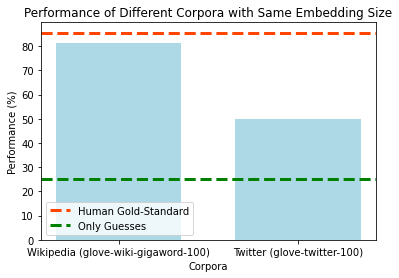

In [8]:
# Let's compare the results of models from different corpora but same embedding size

import matplotlib.pyplot as plt 

corpora_list = ['Wikipedia (glove-wiki-gigaword-100)', 'Twitter (glove-twitter-100)']

# Human gold standard performance retrieved from class results
human_standard_perforance = 85.6

# Average performance if choices were all guesses - on average, 1 correct answers out of 4 guess-words or 25%
guess_performance = 25

# Creating the bar plot
plt.bar(corpora_list, performances_corpora_list, color = 'lightblue', width = 0.7, align = 'center')

plt.xlabel("Corpora")
plt.ylabel("Performance (%)")
plt.title("Performance of Different Corpora with Same Embedding Size")
plt.axhline(human_standard_perforance, label = 'Human Gold-Standard', color = 'orangered', lw = 3, ls = '--')
plt.axhline(guess_performance, label = 'Only Guesses', color = 'green', lw = 3, ls = '--')
plt.legend(loc = 'lower left')
plt.show()



In [9]:
comparison_different_corpora = '''
In the bar plot above, the performance of two different word embedding models, using Wikipedia and Twitter corpora, 
respectively, are compared. Upon seeing the results, it is evident that the Wikipedia model performs significantly
better than the Twitter model with a performance rate of 81% versus only 50% for the Twitter one. The performance
metric in this case relates to the number of correct synonym word answers over the number of questions the model 
answered without guessing. 

This difference in performance can be attributed to the informal nature of social media platforms such as Twitter
where user's typically use slang and may have typos in their texts. This may, in turn, diminish the training 
quality since a word's window will contain this informal text. 

It is also worth noting that neither model performs better than the human gold-standard baseline. This can be due
the optimal hyperparamters not being reached in either case leading to worse performance.
'''
print(comparison_different_corpora)


In the bar plot above, the performance of two different word embedding models, using Wikipedia and Twitter corpora, 
respectively, are compared. Upon seeing the results, it is evident that the Wikipedia model performs significantly
better than the Twitter model with a performance rate of 81% versus only 50% for the Twitter one. The performance
metric in this case relates to the number of correct synonym word answers over the number of questions the model 
answered without guessing. 

This difference in performance can be attributed to the informal nature of social media platforms such as Twitter
where user's typically use slang and may have typos in their texts. This may, in turn, diminish the training 
quality since a word's window will contain this informal text. 

It is also worth noting that neither model performs better than the human gold-standard baseline. This can be due
the optimal hyperparamters not being reached in either case leading to worse performance.



**2) 2 new models from the same corpus but different embedding sizes**

In [ ]:
# Let's use a model from Wikipedia corpora with embedding size of 50
model_glove_wiki_50 = api.load("glove-wiki-gigaword-50")

# Let's also use a model from Wikipedia corpora with embedding size of 300 instead
model_glove_wiki_300 = api.load("glove-wiki-gigaword-300")

In [ ]:
performance_wiki_50 = compute_synonyms(model_glove_wiki_50, "glove-wiki-gigaword-50")
performance_wiki_300 = compute_synonyms(model_glove_wiki_300, "glove-wiki-gigaword-300")

performances_embedding_list = [performance_wiki_50,performance_wiki_100,performance_wiki_300]

In [ ]:
# Let's compare the results of models from same corpora but with different embedding size

embedding_size_list = ['50 (glove-wiki-gigaword-50)','100 (glove-wiki-gigaword-100)','300 (glove-wiki-gigaword-300)']

# Creating the bar plot
plt.bar(embedding_size_list, performances_embedding_list, color = 'lightblue', width = 0.6)
plt.xticks(rotation = 20)

plt.xlabel("Embedding Size")
plt.ylabel("Performance (%)")
plt.title("Performance of Wikipedia Corpora with Different Embedding Sizes")
plt.axhline(human_standard_perforance, label = 'Human Gold-Standard', color = 'orangered', lw = 3, ls = '--')
plt.axhline(guess_performance, label = 'Only Guesses', color = 'green', lw = 3, ls = '--')
plt.legend(loc = 'lower left')
plt.show()

In [ ]:
comparison_different_embedding_size = '''
In the bar plot above, the performance of three word embedding models stemming from the same corpora
but each with different embedding sizes are compared. It is evident that the model with the highest embedding size
displayed the highest performance. This difference in performance can be due to a more optimal value for this
hyper-parameter being reached when the embedding size was equal to 300. A higher dimensionality in this case may 
have been more optimal if the content of the corpora contained more information allowing for a higher 
dimensionality to capture greater lexical detail. 

Moreover, an embedding size of 300 allowed the model to perform at a greater level than the human gold-standard
baseline of 85.6%.
'''

print(comparison_different_embedding_size)

In [ ]:
# Let's compare the results of all models 

performances_all_models_list = [performance_google_300,performance_wiki_100,performance_twitter_100,performance_wiki_50,performance_wiki_300]
model_names_list = ["word2vec-google-news-300","glove-wiki-gigaword-100","glove-twitter-100","glove-wiki-gigaword-50","glove-wiki-gigaword-300"]

# Creating the bar plot
plt.figure(figsize=(7, 5))
plt.bar(model_names_list, performances_all_models_list, color = 'lightblue', width = 0.7)
plt.xticks(rotation = 35)

plt.xlabel("Model Name")
plt.ylabel("Performance (%)")
plt.title("Performance of Different Word Embedding Models")
plt.axhline(human_standard_perforance, label = 'Human Gold-Standard', color = 'orangered', lw = 3, ls = '--')
plt.axhline(guess_performance, label = 'Only Guesses', color = 'green', lw = 3, ls = '--')
plt.legend(loc = 'lower left')
plt.show()


In [ ]:
comparison_all_models = '''
In the bar plot above, the performances of all models are compared. It is shown that the models from Google News 
and Wikipedia corpora, both with an embedding size of 300 performed the best with a rate of 88%. 
'''

print(comparison_all_models)